# EuroSAT Image Classification — Full Notebook

This notebook demonstrates loading the EuroSAT RGB dataset (via TensorFlow Datasets), preprocessing, transfer-learning training (MobileNetV2), evaluation (accuracy, precision, recall, F1, confusion matrix, ROC AUC, top-3 accuracy), saving the model, prediction on a single image, and retraining with local `data/` folders.

**Notes:**
- This notebook assumes you have `tensorflow`, `tensorflow-datasets`, `scikit-learn`, and the `src/` package available (see `requirements.txt`).
- You can also replace the TFDS loading with local `data/train` and `data/test` folders if you prefer.

In [1]:
# Imports and environment checks
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, top_k_accuracy_score
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## Load EuroSAT from TFDS (RGB)
We split dataset into train/val/test. For quicker runs, reduce the training fraction.

In [2]:
# Load Eurosat rgb via TFDS
(ds_all, ), ds_info = tfds.load('eurosat/rgb', split=['train'], with_info=True, as_supervised=True)
print(ds_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.PD7T6Y_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Im

In [3]:
# Create train/val/test splits from the single 'train' split
total = ds_info.splits['train'].num_examples
print("Total examples:", total)

# We'll use an 70/20/10 split
train_split = 'train[:70%]'
val_split = 'train[70%:90%]'
test_split = 'train[90%:]'

(ds_train, ds_val, ds_test), ds_info = tfds.load('eurosat/rgb', split=[train_split, val_split, test_split], with_info=True, as_supervised=True)
print(ds_info.features)


Total examples: 27000
FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


## Preprocessing: resizing and batching
We will preprocess images to 224x224 and use MobileNetV2 preprocessing function.

In [4]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    label = tf.cast(label, tf.int32)
    return image, label

def prepare(ds, shuffle=False):
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = prepare(ds_train, shuffle=True)
val_ds = prepare(ds_val)
test_ds = prepare(ds_test)


## Inspect classes and a few sample images

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


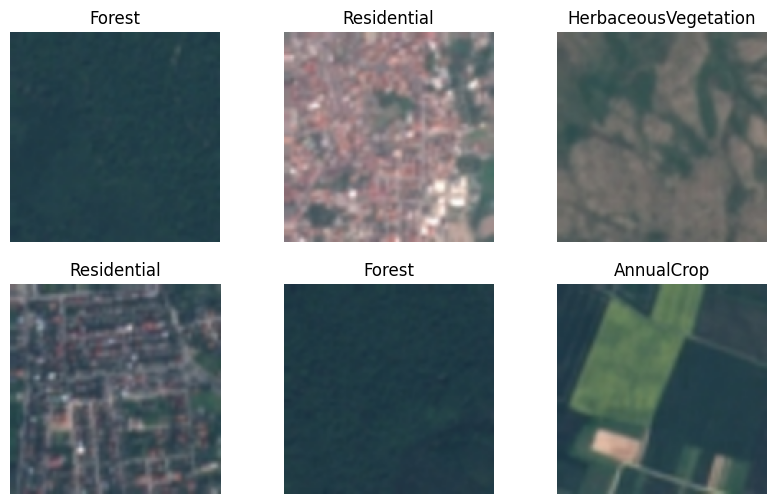

In [5]:
class_names = ds_info.features['label'].names
print("Classes:", class_names)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for i, (img, lbl) in enumerate(ds_train.take(6)):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(tf.cast(tf.image.resize(img, (128,128)), tf.uint8))
    plt.title(class_names[int(lbl.numpy())])
    plt.axis('off')
plt.show()


## Build transfer-learning model (MobileNetV2)

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

def build_model(num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = ds_info.features['label'].num_classes
model = build_model(num_classes)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train (first stage: frozen base)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = "models/model_latest.h5"
os.makedirs("models", exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=callbacks)


Epoch 1/8
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5957 - loss: 1.2297

591/591 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.5959 - loss: 1.2289 - val_accuracy: 0.8900 - val_loss: 0.3195 - learning_rate: 1.0000e-04
Epoch 2/8
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8683 - loss: 0.3860

591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.8683 - loss: 0.3860 - val_accuracy: 0.9137 - val_loss: 0.2515 - learning_rate: 1.0000e-04
Epoch 3/8
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8907 - loss: 0.3220

591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.8908 - loss: 0.3219 - val_accuracy: 0.9230 - val_loss: 0.2294 - learning_rate: 1.0000e-04
Epoch 4/8
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9029 - loss: 0.2740

591/591 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.9029 - loss: 0.2740 - val_accuracy: 0.9293 - val_loss: 0.2154 - learning_rate: 1.0000e-04
Epoch 5/8
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9121 - loss: 0.2491

591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9121 - loss: 0.2491 - val_accuracy: 0.9278 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 6/8
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9145 - loss: 0.2424

591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9145 - loss: 0.2423 - val_accuracy: 0.9300 - val_loss: 0.2040 - learning_rate: 1.0000e-04
Epoch 7/8
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9235 - loss: 0.2241

591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.9235 - loss: 0.2241 - val_accuracy: 0.9359 - val_loss: 0.1960 - learning_rate: 1.0000e-04
Epoch 8/8
591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9250 - loss: 0.2161 - val_accuracy: 0.9335 - val_loss: 0.1967 - learning_rate: 1.0000e-04


## Fine-tune (unfreeze some of the base model)

In [8]:
# The MobileNetV2 base model layers are embedded directly into the 'model'
# from index 1 ('Conv1') to index 153 ('out_relu'), based on the debug output.
# The custom classification head layers are from index 154 onwards.

# First, ensure all MobileNetV2 layers are set to trainable.
# This corresponds to layers from index 1 up to index 153.
for i in range(1, 154): # Indices 1 through 153 (inclusive) for MobileNetV2 backbone
    model.layers[i].trainable = True

# Now, re-freeze the initial part of the MobileNetV2 backbone.
# The original intent was to unfreeze the 'last 30 layers' of the base.
# If there are 153 layers in the MobileNetV2 part (indices 1 to 153),
# then the last 30 layers would be from index (153 - 30 + 1) = 124 to 153.
# So, we should freeze layers from index 1 to 123 (inclusive).
for i in range(1, 124): # Indices 1 through 123 (inclusive) to freeze
    model.layers[i].trainable = False

# The custom head layers (from index 154 onwards) are expected to be trainable
# and are not part of the base model's trainable adjustments.

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=6, callbacks=callbacks)

Epoch 1/6
591/591 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step - accuracy: 0.8300 - loss: 0.5440 - val_accuracy: 0.9085 - val_loss: 0.2920 - learning_rate: 1.0000e-05
Epoch 2/6
591/591 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9087 - loss: 0.2743 - val_accuracy: 0.9300 - val_loss: 0.2152 - learning_rate: 1.0000e-05
Epoch 3/6
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9253 - loss: 0.2222

591/591 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9253 - loss: 0.2222 - val_accuracy: 0.9387 - val_loss: 0.1775 - learning_rate: 1.0000e-05
Epoch 4/6
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9358 - loss: 0.1807

591/591 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9358 - loss: 0.1807 - val_accuracy: 0.9459 - val_loss: 0.1681 - learning_rate: 1.0000e-05
Epoch 5/6
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9429 - loss: 0.1654

591/591 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.9429 - loss: 0.1654 - val_accuracy: 0.9506 - val_loss: 0.1540 - learning_rate: 1.0000e-05
Epoch 6/6
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9532 - loss: 0.1418

591/591 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9532 - loss: 0.1418 - val_accuracy: 0.9507 - val_loss: 0.1530 - learning_rate: 1.0000e-05


## Evaluation on test set: Accuracy, Precision, Recall, F1, Confusion Matrix, ROC AUC, Top-3 accuracy

In [9]:
# Collect predictions and true labels
y_true = []
y_pred = []
y_proba = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.argmax(axis=1).tolist())
    y_proba.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━

In [10]:
# Top-3 accuracy
top3 = top_k_accuracy_score(y_true, y_proba, k=3, labels=range(num_classes))
print("Top-3 accuracy:", top3)


Top-3 accuracy: 0.9974074074074074


## Save model (already saved by checkpoint)

In [11]:
print('Model saved at', checkpoint_path)

Model saved at models/model_latest.h5


## Prediction demo: single image from TFDS or local file

In [12]:
# Pick a test example from TFDS
for img, lbl in ds_test.take(1):
    test_img = tf.image.resize(img, IMG_SIZE)
    inp = preprocess_input(np.expand_dims(test_img.numpy(), axis=0))
    preds = model.predict(inp)
    top_idx = preds[0].argsort()[-3:][::-1]
    print('Top-3 predictions:')
    for idx in top_idx:
        print(class_names[idx], preds[0][idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Top-3 predictions:
AnnualCrop 0.99943155
PermanentCrop 0.00056552276
Pasture 1.817537e-06


In [13]:
from google.colab import files
uploaded = files.upload()


Saving src.zip to src.zip


In [14]:
!unzip -o src.zip
!ls src


Archive:  src.zip
 extracting: src/__init__.py         
  inflating: src/api.py              
  inflating: src/charts.py           
  inflating: src/model.py            
  inflating: src/prediction.py       
  inflating: src/preprocessing.py    
  inflating: src/retrain_utils.py    
  inflating: src/s3_utils.py         
  inflating: src/src.rar             
  inflating: src/utils.py            
api.py	   __init__.py	prediction.py	  retrain_utils.py  src.rar
charts.py  model.py	preprocessing.py  s3_utils.py	    utils.py


In [17]:
!cp -r sample_data/train data/train
!cp -r sample_data/test data/test


cp: cannot stat 'sample_data/train': No such file or directory
cp: cannot stat 'sample_data/test': No such file or directory


## Retraining with local `data/train` and `data/test` folders
If you have new uploaded images placed into `data/train/<class>` and `data/test/<class>`, you can retrain using the `src.model.train_model` function.

In [15]:
# Example of triggering retrain via src.model using ImageDataGenerator
from src.preprocessing import create_generators
from src.model import train_model

if os.path.exists('data/train') and os.path.exists('data/test'):
    print('Local train/test folders found — running retrain for 3 epochs (demo)...')
    train_gen, val_gen = create_generators('data/train', 'data/test', batch_size=16)
    new_model, new_history = train_model(train_gen, val_gen, out_path='models/model_latest_retrained.h5', epochs=3)
    print('Retraining done, model saved to models/model_latest_retrained.h5')
else:
    print('No local data folders present at data/train and data/test. Place images under these folders to retrain locally.')

No local data folders present at data/train and data/test. Place images under these folders to retrain locally.
